
各列缺失值统计：
nozzle_diameter    153
printing_speed     109
extrusion_speed     89
extrusion_temp      14
extruder_type       12
filament_aspect     10
platform_temp        8
dtype: int64
DataFrame 维度: (1172, 331)


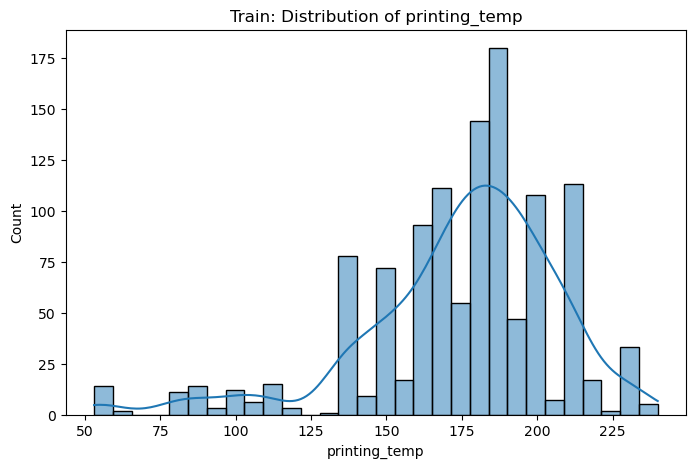

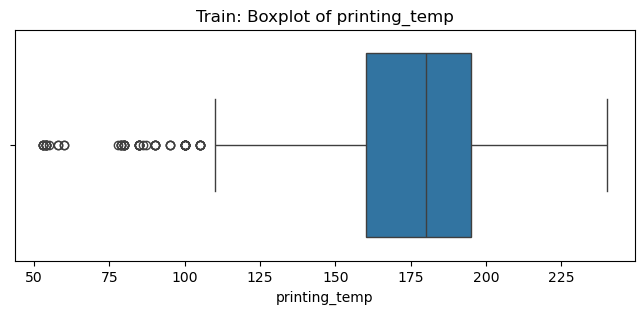

=== Target Descriptive Statistics ===
count    1172.000000
mean      174.903584
std        32.783990
min        53.000000
25%       160.000000
50%       180.000000
75%       195.000000
max       240.000000
Name: printing_temp, dtype: float64 

Skewness: -1.193
Kurtosis: 2.133


In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm import tqdm


# 1. 读取数据
df = pd.read_excel(r"D:\ML-3DPrinting-Project\data\7.9_datasets\2_regression_original.xlsx")

# 2. 删除不需要的列
#drop_cols = ['article']
#df = df.drop(columns=drop_cols)
 
# 3. 丢弃高缺失列 & 目标缺失行
df = df.dropna(axis=1, thresh=len(df)*0.5)
target_col = "printing_temp"
df = df.dropna(subset=[target_col]).reset_index(drop=True)

# 4.统计各列缺失值
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("\n各列缺失值统计：")
print(missing_counts[missing_counts > 0])

# 5. 查看维度
print(f"DataFrame 维度: {df.shape}")

# 1. 划分 X, y
X = df.drop(columns=[target_col])
y = df[target_col]


# 2. 标签分布可视化 & 统计
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True)
plt.title(f"Train: Distribution of {target_col}")
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x=y)
plt.title(f"Train: Boxplot of {target_col}")
plt.show()

print("=== Target Descriptive Statistics ===")
print(y.describe(), "\n")
print(f"Skewness: {skew(y):.3f}")
print(f"Kurtosis: {kurtosis(y):.3f}")

In [2]:
# === Step 2: 数据集划分（在任何编码、标准化之前）===
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 3: 添加缺失标志列（数值列）===
def add_missing_flags(X_raw):
    num_cols = X_raw.select_dtypes(include=['float64', 'int64']).columns
    missing_flags = pd.DataFrame(index=X_raw.index)
    for col in num_cols:
        if X_raw[col].isna().sum() > 0:
            missing_flags[f'{col}_was_missing'] = X_raw[col].isna().astype(int)
    return pd.concat([X_raw, missing_flags], axis=1)

X_train_flagged = add_missing_flags(X_train_raw)
X_test_flagged = add_missing_flags(X_test_raw)

# === Step 4: 类别填补 + One-Hot 编码 ===
cat_cols = X_train_flagged.select_dtypes(include=['object', 'category']).columns
X_train_flagged[cat_cols] = X_train_flagged[cat_cols].fillna("missing")
X_test_flagged[cat_cols] = X_test_flagged[cat_cols].fillna("missing")

X_train_encoded = pd.get_dummies(X_train_flagged, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_flagged, drop_first=True)

# 对齐测试集列（避免缺列）
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
cols = X_train_encoded.columns  # 记录列名用于 SHAP
# === Step 5: 标准化 ===
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)

# === Step 6: 自监督 MLP 填补缺失值 ===
X_train_filled = X_train_scaled.copy()
X_test_filled = X_test_scaled.copy()
X_train_original = X_train_raw.copy()

num_cols = X_train_raw.select_dtypes(include=['float64', 'int64']).columns
filled_features = []

for col in tqdm(num_cols):
    if X_train_original[col].isna().sum() == 0:
        continue

    mask_train = X_train_original[col].isna()
    not_missing_mask = ~mask_train

    valid_cols = [c for c in X_train_scaled.columns if c != col and not X_train_scaled[c].isna().any()]
    if not valid_cols:
        continue

    X_train_feat = X_train_scaled.loc[not_missing_mask, valid_cols]
    y_train_feat = X_train_scaled.loc[not_missing_mask, col]

    model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
    model.fit(X_train_feat, y_train_feat)

    # 填补训练集
    X_missing_feat_train = X_train_scaled.loc[mask_train, valid_cols]
    X_train_filled.loc[mask_train, col] = model.predict(X_missing_feat_train)

    # 填补测试集（注意：使用 train 模型）
    mask_test = X_test_raw[col].isna() if col in X_test_raw.columns else None
    if mask_test is not None and mask_test.any():
        X_missing_feat_test = X_test_scaled.loc[mask_test, valid_cols]
        X_test_filled.loc[mask_test, col] = model.predict(X_missing_feat_test)

    filled_features.append(col)

print(f"已成功填补以下特征缺失: {filled_features}")

100%|███████████████████████████████████████████████████████████████████████████████| 327/327 [00:02<00:00, 120.84it/s]

已成功填补以下特征缺失: ['extrusion_temp', 'extrusion_speed', 'printing_speed', 'platform_temp', 'nozzle_diameter']


✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 5, 'reg_lambda': 10}
📊 RMSE: Train = 9.1766, Test = 13.3011, Gap = -4.1244
📊 MAE : Train = 6.4887, Test = 8.9712, Gap = -2.4826
📊 R²  : Train = 0.9228, Test = 0.8235, Gap = 0.0994


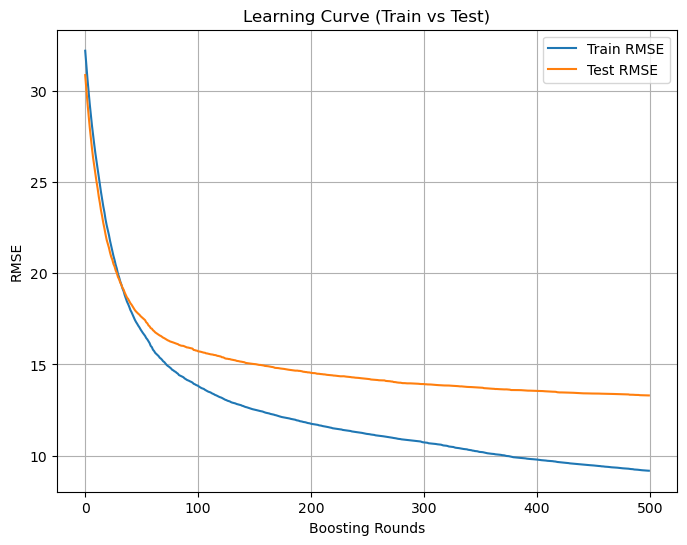

In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ 搜索范围设置更广泛
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.03, 0.05],
    'max_depth': [3, 4],
    'reg_alpha': [1, 5],
    'reg_lambda': [10, 20],
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=10,
    return_train_score=True,
    n_jobs=-1
)

# 2️⃣ 开始参数搜索
grid_search.fit(X_train_filled, y_train)

print("✅ Best Parameters:", grid_search.best_params_)

# 3️⃣ 拿到最优模型，重新训练 + 记录学习曲线
# ✅ 改这里：把 eval_metric 放进构造器
best_model = XGBRegressor(
    **grid_search.best_params_,
    objective='reg:squarederror',
    eval_metric='rmse',  # ✅ 这里是正确的位置
    random_state=42
)

# 训练集与测试集用于画学习曲线
eval_set = [(X_train_filled, y_train), (X_test_filled, y_test)]


# ✅ 改这里：移除 .fit() 中的 eval_metric 参数
best_model.fit(
    X_train_filled, y_train,
    eval_set=eval_set,
    verbose=False
)
eval_result = best_model.evals_result()



# 4️⃣ 预测与评估
y_train_pred = best_model.predict(X_train_filled)
y_test_pred = best_model.predict(X_test_filled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
gap_rmse = train_rmse - test_rmse

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
gap_mae = train_mae - test_mae

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
gap_r2 = train_r2 - test_r2

print(f"📊 RMSE: Train = {train_rmse:.4f}, Test = {test_rmse:.4f}, Gap = {gap_rmse:.4f}")
print(f"📊 MAE : Train = {train_mae:.4f}, Test = {test_mae:.4f}, Gap = {gap_mae:.4f}")
print(f"📊 R²  : Train = {train_r2:.4f}, Test = {test_r2:.4f}, Gap = {gap_r2:.4f}")

# 5️⃣ 学习曲线可视化
train_rmse_curve = eval_result['validation_0']['rmse']
test_rmse_curve = eval_result['validation_1']['rmse']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse_curve, label='Train RMSE')
plt.plot(test_rmse_curve, label='Test RMSE')
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Learning Curve (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()


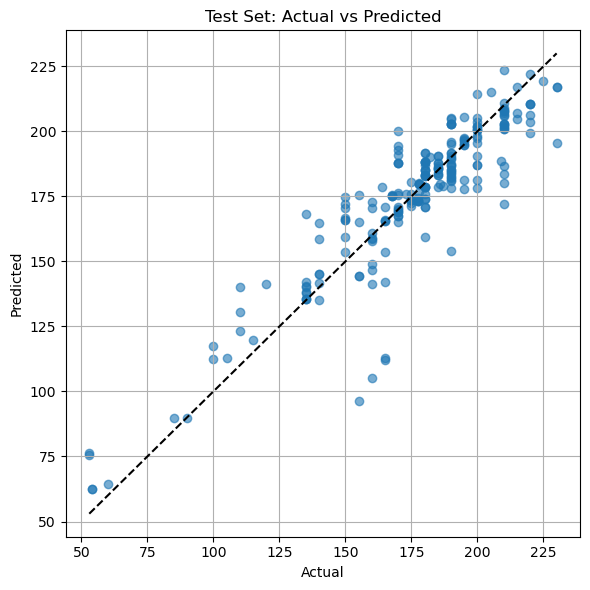

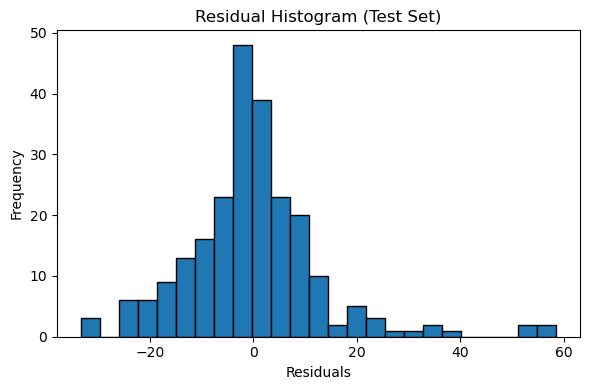

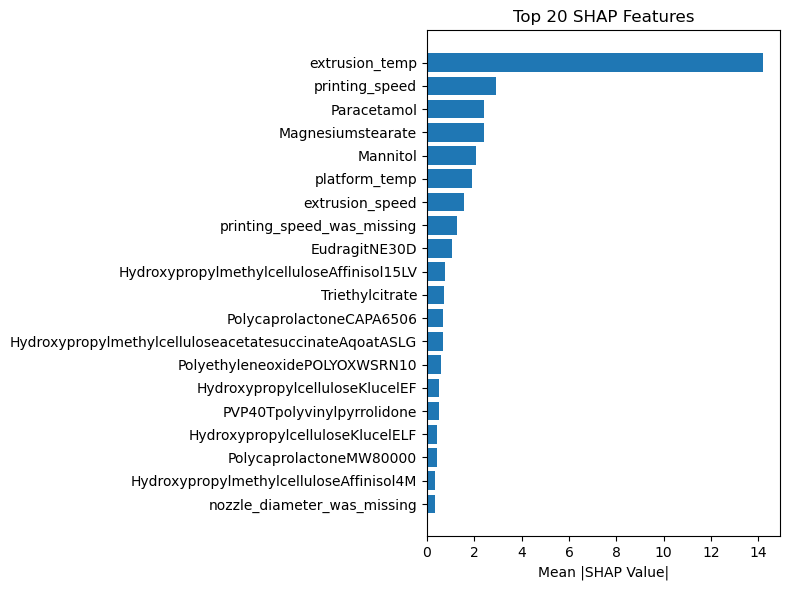

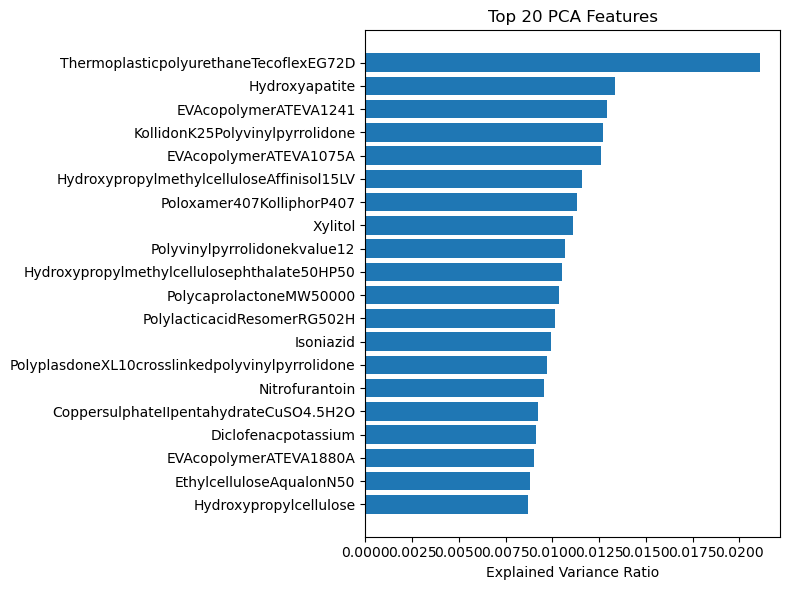

In [6]:
import shap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 预测值
y_train_pred = best_model.predict(X_train_filled)
y_test_pred = best_model.predict(X_test_filled)

# ----------- 散点图 -----------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- 残差直方图 -----------
residuals = y_test - y_test_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=25, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram (Test Set)')
plt.tight_layout()
plt.show()

# ----------- SHAP Top 50 特征 -----------
# 计算 SHAP 值
explainer = shap.Explainer(best_model, X_train_filled)
shap_values = explainer(X_train_filled)
shap_values_array = np.abs(shap_values.values).mean(axis=0)

# 额外提取 SHAP Top 50 特征名
shap_top50_indices = np.argsort(shap_values_array)[-50:][::-1]
shap_top_features = [X_train_filled.columns[i] for i in shap_top50_indices]

# 取 Top 20
shap_top_indices = np.argsort(shap_values_array)[-20:][::-1]
shap_top_values = shap_values_array[shap_top_indices]
shap_top_names = [X_train_filled.columns[i] for i in shap_top_indices]


# 可视化（模仿 PCA 图）
plt.figure(figsize=(8, 6))
plt.barh(range(20), shap_top_values[::-1])  # 横向柱状图
plt.yticks(range(20), shap_top_names[::-1])  # Y轴为特征名
plt.xlabel('Mean |SHAP Value|')
plt.title('Top 20 SHAP Features')
plt.tight_layout()
plt.show()



# ----------- PCA Top 50 特征 -----------
pca = PCA(n_components=min(50, X_train_filled.shape[1]))
pca.fit(X_train_filled)
pca_importance = np.argsort(pca.explained_variance_ratio_)[::-1]
pca_top_indices = pca_importance[:50]
pca_top_features = X_train_filled.columns[pca_top_indices].tolist()

# 可视化 Top 20 PCA 特征
top_20_ratio = pca.explained_variance_ratio_[pca_top_indices[:20]]
top_20_names = [X_train_filled.columns[i] for i in pca_top_indices[:20]]

plt.figure(figsize=(8, 6))
plt.barh(range(20), top_20_ratio[::-1])
plt.yticks(range(20), top_20_names[::-1])
plt.xlabel('Explained Variance Ratio')
plt.title('Top 20 PCA Features')
plt.tight_layout()
plt.show()


In [7]:
from collections import Counter
from sklearn.preprocessing import StandardScaler

# 特征并集（不去交集，只用于打印）
all_top_features = shap_top_features + pca_top_features
selected_features = list(set(all_top_features))  # ✅ 并集

# 打印交集，仅供参考
feature_counter = Counter(all_top_features)
overlapped_features = [feat for feat, count in feature_counter.items() if count == 2]
print(f"👀 SHAP和PCA交集特征数: {len(overlapped_features)}\n{overlapped_features}")
print(f"✅ 最终用于建模的特征数（并集）: {len(selected_features)}")

# 标准化特征
X_selected = X_train_filled[selected_features]
feature_names = X_selected.columns

scaler = StandardScaler()
X_selected_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=feature_names)

# 测试集也准备好
X_test_selected = X_test_filled[selected_features]
X_test_scaled = scaler.transform(X_test_selected)

👀 SHAP和PCA交集特征数: 5
['HydroxypropylmethylcelluloseAffinisol15LV', 'PolyethyleneglycolPEG8000', 'Hydroxyzinedihydrochloride', 'BenzoinOleogumresin', 'EthylcelluloseAqualonN50']
✅ 最终用于建模的特征数（并集）: 95


✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 5, 'reg_lambda': 10}
📊 RMSE: Train = 9.3061, Test = 13.9885, Gap = -4.6823
📊 MAE : Train = 6.4378, Test = 9.1020, Gap = -2.6642
📊 R2  : Train = 0.9207, Test = 0.8048, Gap = 0.1159


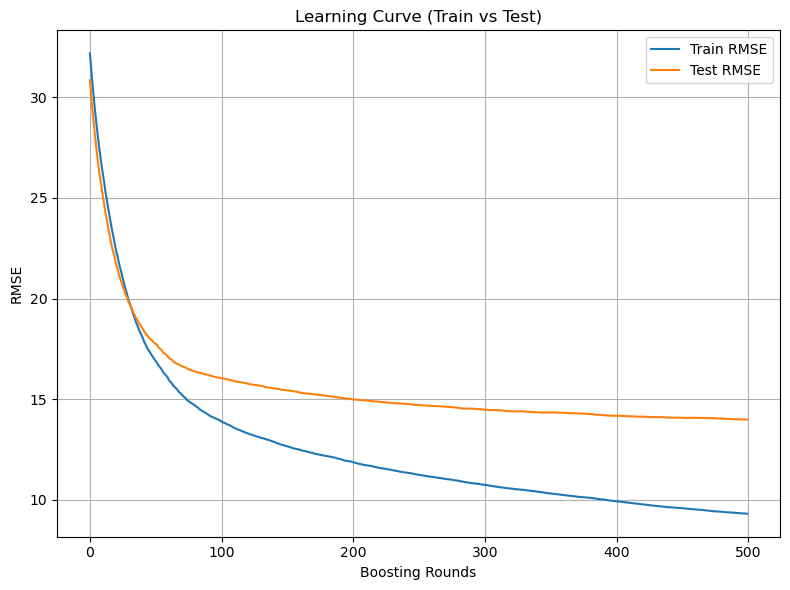

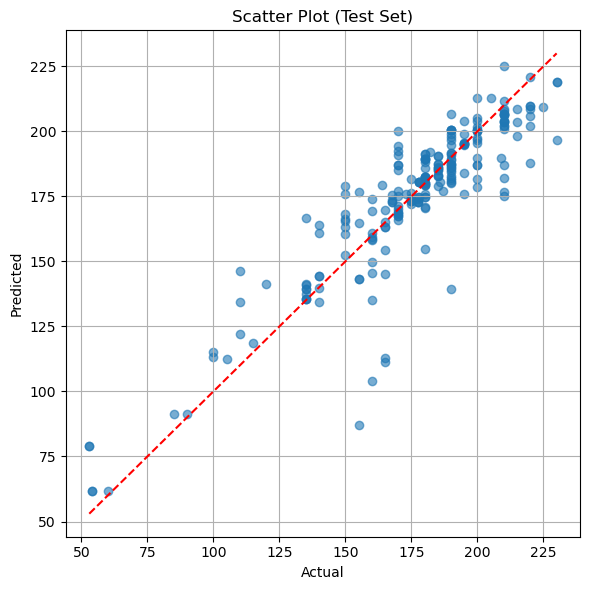

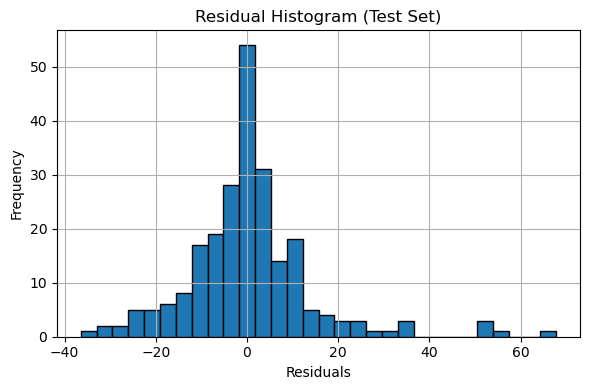

In [17]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

X_selected_scaled = pd.DataFrame(X_selected_scaled, columns=selected_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features)

# 设定参数搜索范围（可按需扩展）
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.03, 0.05],
    'max_depth': [3, 4],
    'reg_alpha': [1, 5],
    'reg_lambda': [10, 20],
}

# GridSearchCV 设置
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1)

# 开始搜索
grid_search.fit(X_selected_scaled, y_train)
print("✅ Best Parameters:", grid_search.best_params_)

# 使用最佳参数训练完整训练集

# 3️⃣ 拿到最优模型，重新训练 + 记录学习曲线

best_model = XGBRegressor(
    **grid_search.best_params_,
    objective='reg:squarederror',
    eval_metric='rmse',  # ✅ 这里是正确的位置
    random_state=42
)
eval_set = [(X_selected_scaled, y_train), (X_test_scaled, y_test)]


best_model.fit(
    X_selected_scaled, y_train,
    eval_set=eval_set,
    verbose=False,
)
eval_result = best_model.evals_result()

# 预测
y_train_pred = best_model.predict(X_selected_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# 指标计算
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
gap_rmse = train_rmse - test_rmse

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
gap_mae = train_mae - test_mae

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
gap_r2 = train_r2 - test_r2

print(f"📊 RMSE: Train = {train_rmse:.4f}, Test = {test_rmse:.4f}, Gap = {gap_rmse:.4f}")
print(f"📊 MAE : Train = {train_mae:.4f}, Test = {test_mae:.4f}, Gap = {gap_mae:.4f}")
print(f"📊 R2  : Train = {train_r2:.4f}, Test = {test_r2:.4f}, Gap = {gap_r2:.4f}")

# 学习曲线
train_rmse_curve = eval_result['validation_0']['rmse']
test_rmse_curve = eval_result['validation_1']['rmse']

plt.figure(figsize=(8, 6))
plt.plot(train_rmse_curve, label='Train RMSE')
plt.plot(test_rmse_curve, label='Test RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Learning Curve (Train vs Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 散点图 + 残差直方图（测试集）
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
residuals = y_test - y_test_pred
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Residual Histogram (Test Set)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

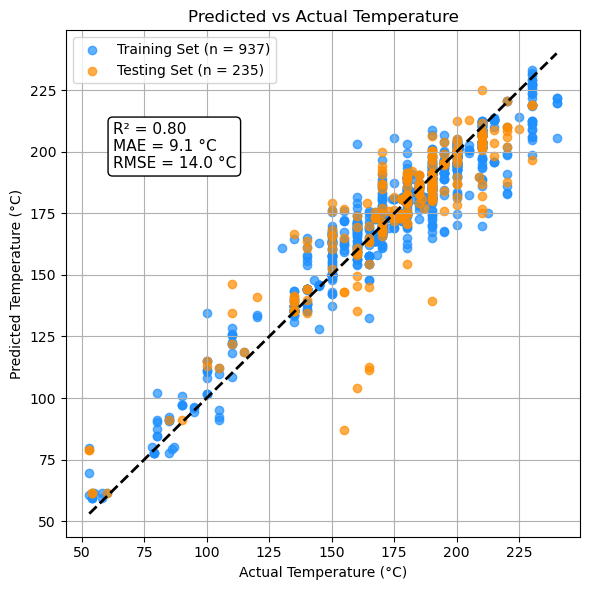

In [18]:
# 🚀 训练 + 测试集混合展示 + 指标标注
plt.figure(figsize=(6, 6))

# 绘制训练集
plt.scatter(y_train, y_train_pred, color='dodgerblue', alpha=0.7,
            label=f'Training Set (n = {len(y_train)})')

# 绘制测试集
plt.scatter(y_test, y_test_pred, color='darkorange', alpha=0.7,
            label=f'Testing Set (n = {len(y_test)})')

# 理想预测线 y = x
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# 坐标轴 & 标题
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted vs Actual Temperature')

# 计算并添加评价指标文本（以测试集为主）
text_x = min_val + (max_val - min_val) * 0.05
text_y = max_val - (max_val - min_val) * 0.25
plt.text(text_x, text_y,
         f"R² = {test_r2:.2f}\nMAE = {test_mae:.1f} °C\nRMSE = {test_rmse:.1f} °C",
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

# 显示图例和布局
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Best Params from GridSearchCV: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
✅ Retrain on Full Training Set:
RMSE: Train = 9.8511, Test = 12.8768, Gap = -3.0257
MAE : Train = 7.2202, Test = 9.2558, Gap = -2.0355
R²  : Train = 0.9111, Test = 0.8346, Gap = 0.0765


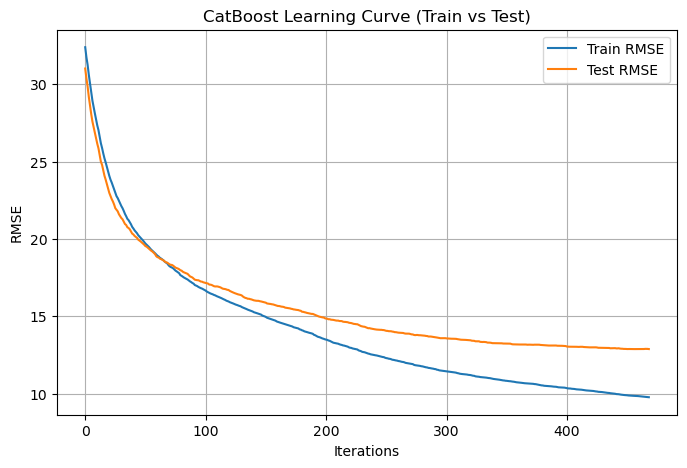

In [19]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# ✨ 定义基础模型（关闭verbose避免输出太多）
cat = CatBoostRegressor(
    random_state=42,
    verbose=0
)

# ✨ 定义超参数搜索范围（可根据需要扩展）
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.03, 0.05],
    'depth': [4],
    'l2_leaf_reg': [1, 3, 5]
}

# ✨ 配置 GridSearchCV
grid_search = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',  # 最终使用 RMSE 作为模型选择标准
    return_train_score=True,
    n_jobs=-1
)

# ✨ 执行超参数搜索（此处使用 X_selected_scaled 和 y_train）
grid_search.fit(X_selected_scaled, y_train)

# ✨ 获取最佳参数
best_params = grid_search.best_params_
print("✅ Best Params from GridSearchCV:", best_params)

# ✅ 1. 拿到最佳参数
best_params = grid_search.best_params_

# ✅ 2. 用最佳参数训练模型（注意 CatBoost 要求用 Pool）
model = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=0
)

eval_pool = Pool(X_test_scaled, y_test)  # ✅ 这个用于评估曲线
train_pool = Pool(X_selected_scaled, y_train)

# ✅ 训练模型并记录学习曲线
model.fit(
    train_pool,
    eval_set=eval_pool,
    use_best_model=True,
    early_stopping_rounds=10
)

# ✅ 3. 预测
y_train_pred = model.predict(X_selected_scaled)
y_test_pred = model.predict(X_test_scaled)

# ✅ 4. 评估指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
gap_rmse = train_rmse - test_rmse

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
gap_mae = train_mae - test_mae

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
gap_r2 = train_r2 - test_r2

print(f"✅ Retrain on Full Training Set:")
print(f"RMSE: Train = {train_rmse:.4f}, Test = {test_rmse:.4f}, Gap = {gap_rmse:.4f}")
print(f"MAE : Train = {train_mae:.4f}, Test = {test_mae:.4f}, Gap = {gap_mae:.4f}")
print(f"R²  : Train = {train_r2:.4f}, Test = {test_r2:.4f}, Gap = {gap_r2:.4f}")

# ✅ 5. 学习曲线
train_curve = model.get_evals_result()['learn']['RMSE']
test_curve = model.get_evals_result()['validation']['RMSE']

plt.figure(figsize=(8, 5))
plt.plot(train_curve, label="Train RMSE")
plt.plot(test_curve, label="Test RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("CatBoost Learning Curve (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()


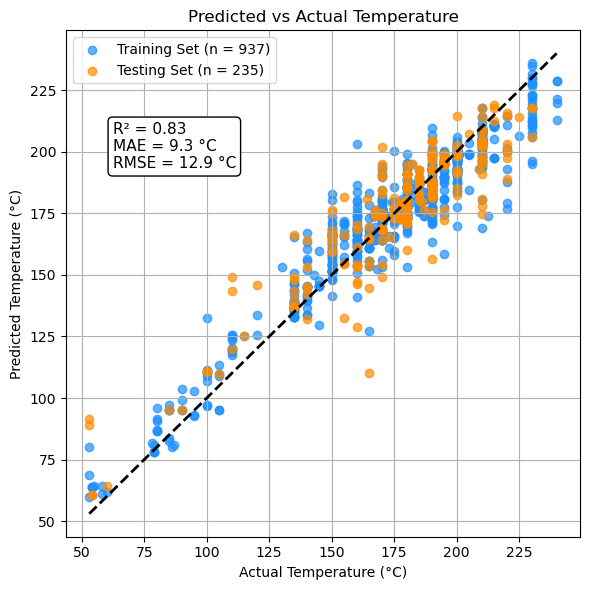

In [20]:
# 🚀 训练 + 测试集混合展示 + 指标标注
plt.figure(figsize=(6, 6))

# 绘制训练集
plt.scatter(y_train, y_train_pred, color='dodgerblue', alpha=0.7,
            label=f'Training Set (n = {len(y_train)})')

# 绘制测试集
plt.scatter(y_test, y_test_pred, color='darkorange', alpha=0.7,
            label=f'Testing Set (n = {len(y_test)})')

# 理想预测线 y = x
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# 坐标轴 & 标题
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted vs Actual Temperature')

# 计算并添加评价指标文本（以测试集为主）
text_x = min_val + (max_val - min_val) * 0.05
text_y = max_val - (max_val - min_val) * 0.25
plt.text(text_x, text_y,
         f"R² = {test_r2:.2f}\nMAE = {test_mae:.1f} °C\nRMSE = {test_rmse:.1f} °C",
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

# 显示图例和布局
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
!pip install eli5

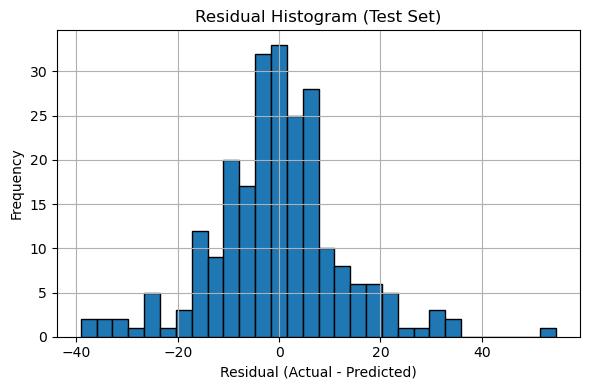

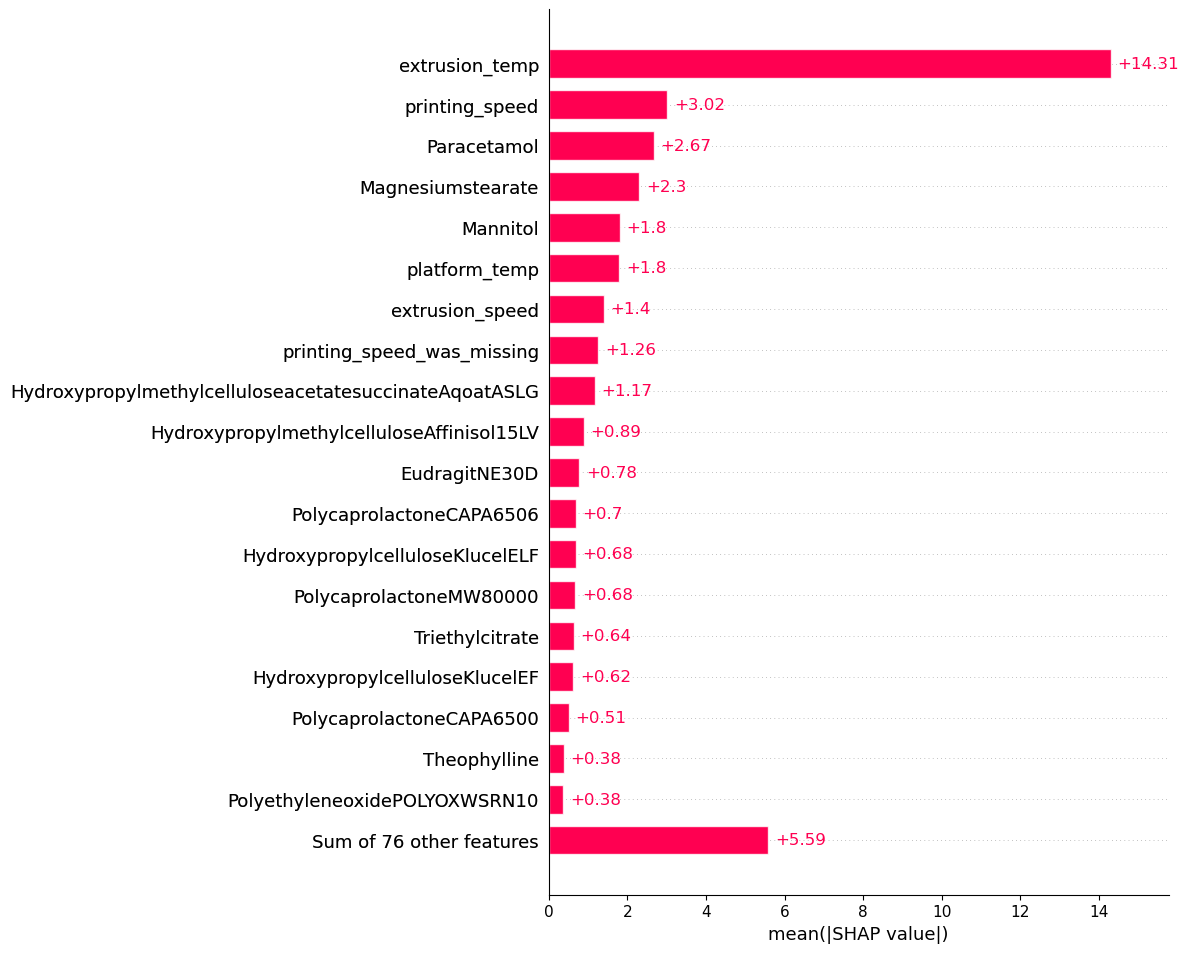

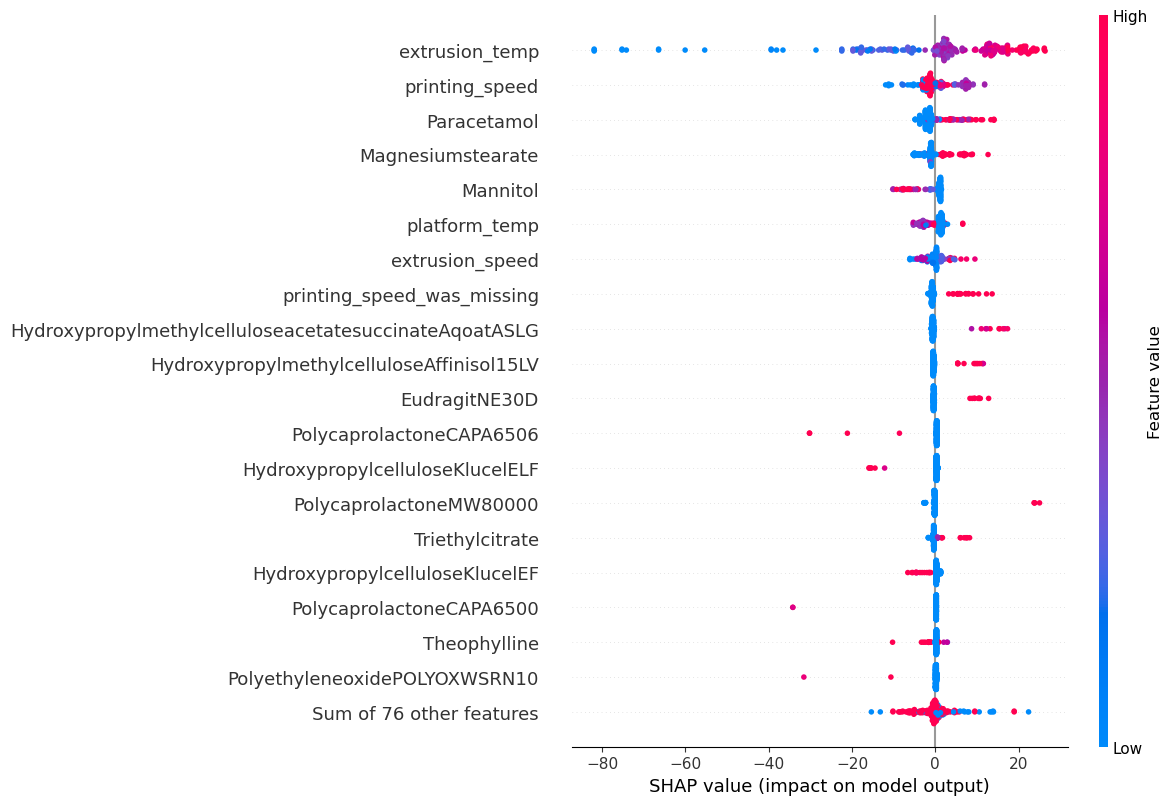

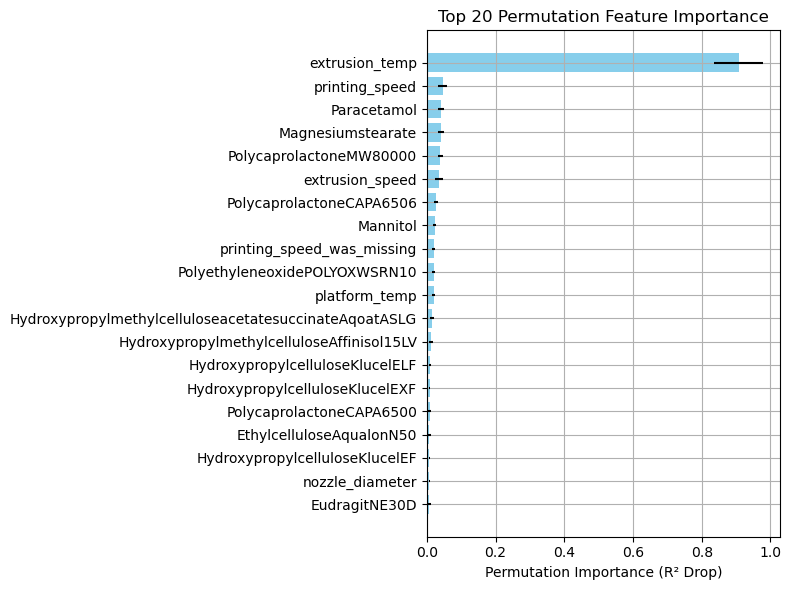

In [24]:
import matplotlib.pyplot as plt

residuals = y_test - y_test_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Histogram (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

import shap

# SHAP for Tree models (如 XGBoost / CatBoost / RF)
explainer = shap.Explainer(best_model)  # 替换为你的模型
shap_values = explainer(X_test_scaled)

# Top20 bar 图
shap.plots.bar(shap_values, max_display=20)

# 小提琴图
shap.plots.beeswarm(shap_values, max_display=20)

from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=30, random_state=42, scoring='r2')

import pandas as pd
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    'feature': X_selected_scaled.columns if hasattr(X_selected_scaled, 'columns') else [f'feature_{i}' for i in range(X_selected_scaled.shape[1])],
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# 画 Top 20 的条形图
top20 = importance_df.head(20)
plt.figure(figsize=(8, 6))
plt.barh(top20['feature'], top20['importance_mean'], xerr=top20['importance_std'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Permutation Importance (R² Drop)')
plt.title('Top 20 Permutation Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 📌 1. 定义模型与参数范围
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# 📌 2. GridSearchCV 搜索最优参数（10折）
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring={
        'rmse': 'neg_root_mean_squared_error',
        'mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    },
    refit='rmse',
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_selected_scaled, y_train)
best_params = grid_search.best_params_
print("✅ Best Params from GridSearchCV:", best_params)

# 📌 3. 用最优参数重新训练模型（全训练集）
model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_selected_scaled, y_train)

# 📌 4. 模型预测
y_train_pred = model.predict(X_selected_scaled)
y_test_pred = model.predict(X_test_scaled)

# 📌 5. 评估指标计算
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
gap_rmse = train_rmse - test_rmse

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
gap_mae = train_mae - test_mae

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
gap_r2 = train_r2 - test_r2

# 📌 6. 打印结果
print(f"\n📊 RMSE: Train = {train_rmse:.4f}, Test = {test_rmse:.4f}, Gap = {gap_rmse:.4f}")
print(f"📊 MAE : Train = {train_mae:.4f}, Test = {test_mae:.4f}, Gap = {gap_mae:.4f}")
print(f"📊 R²  : Train = {train_r2:.4f}, Test = {test_r2:.4f}, Gap = {gap_r2:.4f}")


✅ Best Params from GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

📊 RMSE: Train = 9.5623, Test = 12.9050, Gap = -3.3427
📊 MAE : Train = 6.9113, Test = 8.8567, Gap = -1.9454
📊 R²  : Train = 0.9162, Test = 0.8339, Gap = 0.0824


In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# 1. 定义模型
svr = SVR()

# 2. 定义参数搜索空间
param_grid = {
    'C': [1, 10],              # 正则化参数
    'epsilon': [0.1, 0.2],     # ε-tube 的宽度
    'kernel': ['rbf']          # 常用核函数
}

# 3. 进行 GridSearchCV（10-fold）
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=10,
    scoring='neg_root_mean_squared_error',  # 或换 'neg_mean_absolute_error' 等
    return_train_score=True,
    refit='neg_root_mean_squared_error',    # 指定用于 refit 的指标
    n_jobs=-1
)

# 4. 执行搜索
grid_search.fit(X_selected_scaled, y_train)

# 5. 输出最优参数
print("✅ Best Parameters from GridSearchCV:", grid_search.best_params_)


# 7. 使用最佳参数重新训练模型
best_svr = SVR(**grid_search.best_params_)
best_svr.fit(X_selected_scaled, y_train)

# 8. 在测试集上进行预测
y_train_pred = best_svr.predict(X_selected_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

# 9. 评估性能指标
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
gap_rmse = train_rmse - test_rmse

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
gap_mae = train_mae - test_mae

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
gap_r2 = train_r2 - test_r2

# 10. 打印测试集评估结果
print("\nTest Set Performance of SVR (best params):")
print(f"🏋️ RMSE: Train = {train_rmse:.4f}, Test = {test_rmse:.4f}, Gap = {gap_rmse:.4f}")
print(f"🎯 MAE : Train = {train_mae:.4f}, Test = {test_mae:.4f}, Gap = {gap_mae:.4f}")
print(f"📈 R^2 : Train = {train_r2:.4f}, Test = {test_r2:.4f}, Gap = {gap_r2:.4f}")


✅ Best Parameters from GridSearchCV: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}

Test Set Performance of SVR (best params):
🏋️ RMSE: Train = 19.3245, Test = 20.2278, Gap = -0.9033
🎯 MAE : Train = 10.6047, Test = 11.5098, Gap = -0.9051
📈 R^2 : Train = 0.6579, Test = 0.5918, Gap = 0.0661


In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
param_grid = {
    'hidden_layer_sizes': [(50,), (50, 20), (30, 30)],
    'activation': ['relu'],  # or try 'tanh'
    'alpha': [0.1],
    'learning_rate_init': [0.001, 0.01]
}

mlp = MLPRegressor(max_iter=1000, random_state=42)

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=10,
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    refit='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_selected_scaled, y_train)

print("✅ Best MLP Params:", grid_search.best_params_)

# 用最佳参数 + 加入 early stopping 重新训练
best_mlp = MLPRegressor(
    **grid_search.best_params_,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=42
)

best_mlp.fit(X_selected_scaled, y_train)


y_train_pred = best_mlp.predict(X_selected_scaled)
y_test_pred = best_mlp.predict(X_test_scaled)

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
gap_rmse = train_rmse - test_rmse

# MAE
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
gap_mae = train_mae - test_mae

# R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
gap_r2 = train_r2 - test_r2

print("\n🧠 Test Set Performance of MLP (best params):")
print(f"🏋️ RMSE: Train = {train_rmse:.4f}, Test = {test_rmse:.4f}, Gap = {gap_rmse:.4f}")
print(f"🎯 MAE : Train = {train_mae:.4f}, Test = {test_mae:.4f}, Gap = {gap_mae:.4f}")
print(f"📈 R^2 : Train = {train_r2:.4f}, Test = {test_r2:.4f}, Gap = {gap_r2:.4f}")


✅ Best MLP Params: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (30, 30), 'learning_rate_init': 0.01}

🧠 Test Set Performance of MLP (best params):
🏋️ RMSE: Train = 14.9082, Test = 58.8420, Gap = -43.9338
🎯 MAE : Train = 10.2584, Test = 18.2491, Gap = -7.9907
📈 R^2 : Train = 0.7964, Test = -2.4543, Gap = 3.2506
